# This notebook is used to define TPR/FPR for cosmic-cosmic pairs and noncosmic-noncosmic pairs as well as to plot AUROC curves

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
import operator
from scipy.stats import mannwhitneyu
from sklearn.metrics import auc
import random
random.seed(1234)
import os
import string

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/epistasis_codes/mutex_data

/content/drive/.shortcut-targets-by-id/1M7ksQHsnBabT6t_aAy6H6k_JHTqvUBjb/epistasis_codes/mutex_data


In [ ]:
dict_tissue={'BLCA': 'Bladder',
            'BRCA': 'Breast',
            'COADREAD': 'Colon',
            'LUAD': 'Lung',
            'LUSC': 'Lung',
            'SKCM': 'Skin',
            'STAD': 'Stomach',
            'UCEC': 'Uterus'
            }

#for figure titles
dict_methods = {'discover': 'DISCOVER',
               'discover_strat': 'DISCOVER Strat',
               'fishers': 'Fisher\'s Exact Test',
               'megsa': 'MEGSA',
               'memo': 'MEMO',
               'wext': 'WExT'}

# load cosmic and intact
#inpath_mla = '../../version 11 - ep data MLA logit unfiltered/'
#cosmic_infile = inpath_mla+'data/Census_allFri_Apr_26_12_49_57_2019.tsv'
inpath_mla = '../mutex_data/MLA_ep_mutation_filtered_all_genes/'
cosmic_infile = '../mutex_data/Census_allFri_Apr_26_12_49_57_2019.tsv'

with open(cosmic_infile,'r') as f:
    cosmic_genes = [line.split()[0].upper() for line in f.readlines()[1:]]
print(len(cosmic_genes))


#intact_edge_file = inpath_mla+'data/intact_nodupl_edge_file.txt'
#intact_index_file = inpath_mla+'data/intact_nodupl_index_file.txt'

intact_edge_file = '../mutex_data/intact_nodupl_edge_file.txt'
intact_index_file = '../mutex_data/intact_nodupl_index_file.txt'

with open(intact_index_file, 'r') as f:
    indices = {line.split()[0]:line.split()[1] for line in f.readlines()}

with open(intact_edge_file, 'r') as f:
    edges = [(indices[line.split()[0]].upper(),indices[line.split()[1]].upper()) for line in f.readlines()]
len(edges)

intact_genes_list = list(indices.values())
intact_genes_list[:5]

723


['""CHEBI', '100147744', '1B', '1EFV', '1KLA']

In [ ]:
##TSN
c = 'COADREAD'
t=20
tissue = dict_tissue[c]
tsn_conf_threshold = 0.0
perc = 0.25
infile_tsn = '../version ziv - GTEx TSN analysis/data/gtex_tsn_fractions_intact_filtered/edges_gtex_intact_filtered_{}.txt'.format(tissue)


count = 0
with open(infile_tsn) as f:
    lines_tsn=f.readlines()
    dict_tsn_conf = {(line.split()[0],line.split()[1]):float(line.split()[2]) for line in lines_tsn}
    tsn_edges = [(line.split()[0].upper(),line.split()[1].upper()) for line in lines_tsn if float(line.split()[2])>=tsn_conf_threshold]
    tsn_top_edges = [(line.split()[0].upper(),line.split()[1].upper()) for line in lines_tsn if float(line.split()[2])>=(1-perc)]
    tsn_bottom_edges = [(line.split()[0].upper(),line.split()[1].upper()) for line in lines_tsn if float(line.split()[2])<=perc]
    
    
print(len(tsn_edges), len(dict_tsn_conf),len(tsn_top_edges), len(tsn_bottom_edges))

#binary mutation matrix
#inpath = '../../version y - DISCOVER orig/data/binary_matrices_all_genes_ep_mutation_filtered/'#binary_matrices_alterations_unfiltered/'
inpath = '../mutex_data/binary_matrices_all_genes_ep_mutation_filtered/'#binary_matrices_alterations_unfiltered/'

df = pd.read_csv(inpath + c + '_TML_binary_sm.txt', sep= '\t', index_col=0, header=0, skipinitialspace=True)

df.drop('y',1,inplace=True)
#         print(df.shape)
#         print(df.head())

df.drop([col for col, val in df.sum().iteritems() if val <= t], axis=1, inplace=True)

df


In [ ]:
coadred0="../version ziv - GTEx TSN analysis/data/gtex_tsn_fractions_intact_filtered_applied_threshold/edges_gtex_intact_filtered_Colon_0.0.txt"

count = 0
with open(coadred0) as f:
    coadred01=f.readlines()
    print(len(coadred01))

88133


In [ ]:
#methods = ['discover','fishers', 'wext']#'megsa','wext']#,  'memo']#'discover_strat','fishers', 'megsa']
methods = ['discover','discover_strat','fishers','megsa', 'memo','wext']


mutex_cooc = "mutex" # "mutex", "cooc"
'''
dict_inpath = {'discover': '../../version y - DISCOVER orig/',
               'discover_strat': '../../version y - DISCOVER orig/',
               'fishers': '../../version yi - FISHERS EXACT/',
               'megsa': '../../version yiii - MEGSA/',
               'memo': '../../version yii - MEMO/memo/',
               'wext': '../../version yiv - WEXT/'
              }
'''
dict_inpath = {'discover': '../mutex_data/discover_mutation_filtered_ep_data/',
               'discover_strat': '../mutex_data/discover_mutation_filtered_ep_data',
               'fishers': '../mutex_data/fishers_mutation_filtered_ep_data/',
               'megsa': '../mutex_data/megsa_mutation_filtered_ep_data/',
               'memo': '../mutex_data/memo_mutation_filtered_ep_data/',
               'wext': '../mutex_data/wext_mutation_filtered_ep_data/'
              }

inpath_mla = '../mutex_data/MLA_ep_mutation_filtered_all_genes/'
cosmic_infile = '../mutex_data/Census_allFri_Apr_26_12_49_57_2019.tsv'
'''
if mutex_cooc == "mutex":
    ## assign method paths to a dict
    dict_infile = {}
    dict_infile_intact = {}
    for m in methods:
        if m == 'discover':
            suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_normal_{}.txt'.format(m,c,m,t)
            suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_pairs_q1.0_normal_intact_filtered_subset{}.txt'.format(m,c,t)
        elif m == 'discover_strat':
            suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_stratified_{}.txt'.format('discover',c,'discover',t)
            suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_pairs_q1.0_stratified_intact_filtered_subset{}.txt'.format('discover',c,t)    
        else:
            suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_{}.txt'.format(m,c,m,t)
            suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_{}_pairs_intact_filtered_subset{}.txt'.format(m,c,m,t)

        dict_infile[m] = dict_inpath[m] + suffix
        dict_infile_intact[m] = dict_inpath[m] + suffix_intact 
        '''

if mutex_cooc == "mutex":
    ## assign method paths to a dict
    dict_infile = {}
    dict_infile_intact = {}
    for m in methods:
        if m == 'discover':
            suffix = '/{}_{}_result_mutations_all_genes_q1.0_normal_{}.txt'.format(c,m,t)
            suffix_intact = '/{}_pairs_q1.0_normal_intact_filtered_subset{}.txt'.format(c,t)
        elif m == 'discover_strat':
            suffix = '/{}_{}_result_mutations_all_genes_q1.0_stratified_{}.txt'.format(c,'discover',t)
            suffix_intact = '/{}_pairs_q1.0_stratified_intact_filtered_subset{}.txt'.format(c,t)    
        else:
            suffix = '/{}_{}_result_mutations_all_genes_{}.txt'.format(c,m,t)
            suffix_intact = '/{}_{}_pairs_intact_filtered_subset{}.txt'.format(c,m,t)

        dict_infile[m] = dict_inpath[m] + suffix
        dict_infile_intact[m] = dict_inpath[m] + suffix_intact 


In [ ]:
def get_pvalues(filename, reference_genes=cosmic_genes,pvalue_threshold=0.05,pvalue_position=3, ref_edges=tsn_edges):
    """ge mutex pvalues from file"""
       
    #read file and get min nonzero pvalue    
    with open(filename, 'r') as f:
        lines = f.readlines()[1:]
        
        list_pvals = []
        for line in tqdm(lines):
            val = float(line.split()[pvalue_position])
            if val!=0:
                list_pvals.append(val)
        min_pval = min(list_pvals)
        del list_pvals
    print('min pval:',min_pval)

    dict_temp = {g:{} for g in tsn_genes}

    for line in tqdm(lines):
        line = line.strip().split('\t')

        g1 = line[1]
        g2 = line[2]
        
#         if (g1,g2) in tsn_edges or (g2,g1) in tsn_edges:
            
        ## added post memo run
        p_temp = float(line[pvalue_position])

        if p_temp == 0:
            if m=='wext':
                p=0.0
            else:
                p = -np.log(min_pval)
        else:
            p = -np.log(p_temp)

        if g1 in dict_temp and g2 not in dict_temp[g1]:
            dict_temp[g1][g2] = p
        if g2 in dict_temp and g1 not in dict_temp[g2]:
            dict_temp[g2][g1] = p

    return dict_temp
    

In [ ]:

tsn_genes = set()
for g1,g2 in tsn_edges:
    tsn_genes.update([g1,g2])
print(len(tsn_genes))
tsn_genes.intersection_update(set(df.columns.tolist()))
len(tsn_genes)


14364


1091

In [ ]:
dict_mex = {}
for m in tqdm(methods):#['discover', 'fishers']:
    print(m)
    filename = dict_infile[m]
    dict_mex[m]=get_pvalues(filename)

## FPR TPR

In [ ]:
genes = df.columns.to_list()
dict_tsn_conf_cosmic_nb = {k:v for k,v in dict_tsn_conf.items() if k[0] in cosmic_genes and k[1] in cosmic_genes and k[0] in genes and k[1] in genes}
len(dict_tsn_conf_cosmic_nb)

98

In [ ]:
top_n=1.0
bottom_n = 0.5
dict_tsn_conf_cosmic_nb_top = {k:v for k,v in dict_tsn_conf_cosmic_nb.items() if v>=top_n}
dict_tsn_conf_cosmic_nb_bottom = {k:v for k,v in dict_tsn_conf_cosmic_nb.items() if v<=bottom_n}
len(dict_tsn_conf_cosmic_nb_top),len(dict_tsn_conf_cosmic_nb_bottom)


(63, 15)

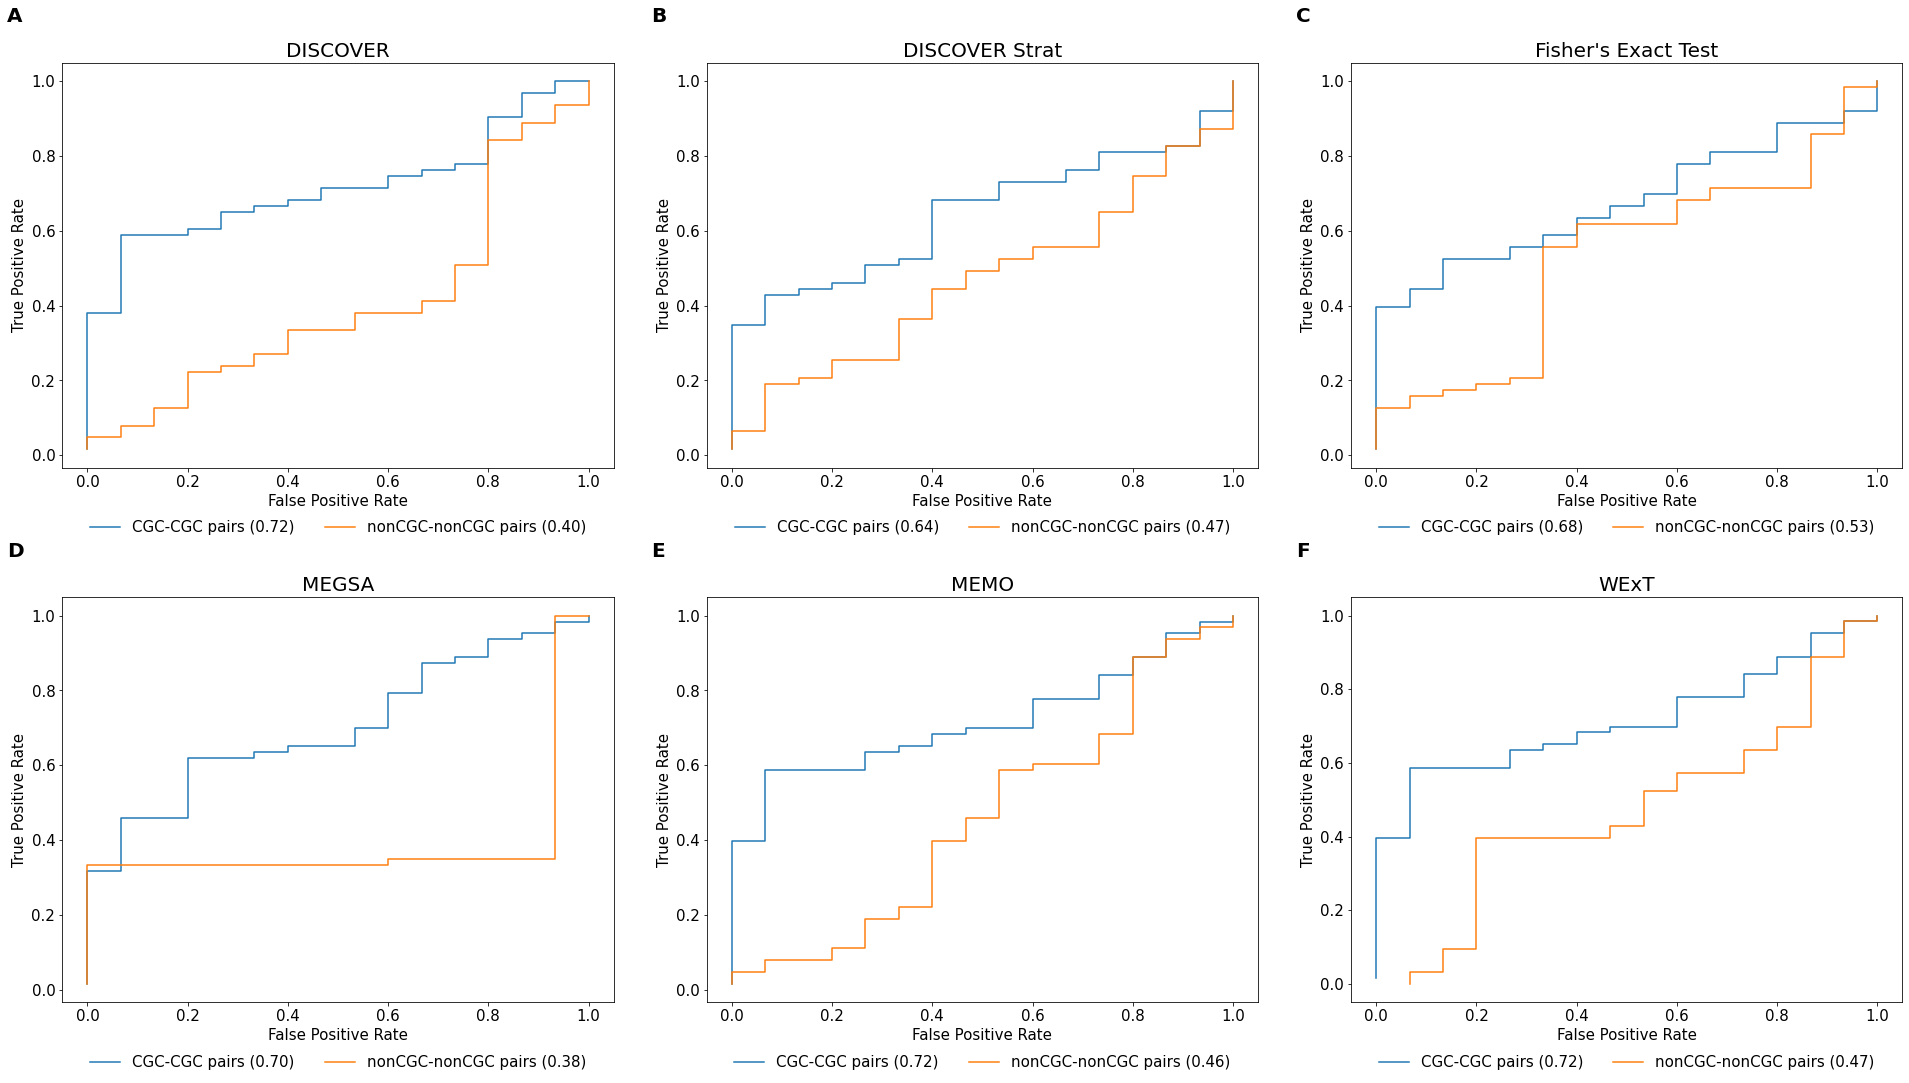

In [ ]:
#outpath = '../out/figure_tsn_AUROC/'
outpath = '../version ziv - GTEx TSN analysis/out/figure_tsn_AUROC/'

if not os.path.exists(outpath):
    os.makedirs(outpath)
    
#fig,axes = plt.subplots(1,len(methods),figsize=(40,6)) #26 for 4, 20 for 3, 30 for 5,40 for 6
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(27,15)) #only for Coadread t20 with 6 methods. 
#axiter=axes.flat
axes = np.array(axes)
axiter = axes.flat

for i, (ax,m) in enumerate(zip(axiter,methods)):


    # dict_mex_temp_top = {k:dict_mex[m][k[0]][k[1]] for k,v in dict_tsn_conf_cosmic_nb_top.items()}
    # dict_mex_temp_bottom = {k:dict_mex[m][k[0]][k[1]] for k,v in dict_tsn_conf_cosmic_nb_bottom.items()}
    # COSMIC-COSMIC
    list_vals = []

    for k,v in dict_tsn_conf.items():
        g1,g2=k
        if g1 in cosmic_genes and g2 in cosmic_genes and g1 in genes and g2 in genes: 
            if m!='wext':
                if v>=top_n:
                    list_vals.append([g1,g2,dict_mex[m][g1][g2],1])
                elif v<=bottom_n:
                    list_vals.append([g1,g2,dict_mex[m][g1][g2],0])
            else:
                if v>=top_n:
                    if g2 in dict_mex[m][g1]:
                        list_vals.append([g1,g2,dict_mex[m][g1][g2],1])
                    else:
                        continue#list_vals.append([g1,g2,0,1])
                elif v<=bottom_n:
                    if g2 in dict_mex[m][g1]:
                        list_vals.append([g1,g2,dict_mex[m][g1][g2],0])
                    else:
                        continue#list_vals.append([g1,g2,0,0])
            
            
    df_rank = pd.DataFrame(list_vals, columns=['g1', 'g2', 'mex','class'])
    df_rank.sort_values('mex', inplace=True,ascending=False)

    '''
    TPR = Sensitivity = sum_true/len(dict_tsn_conf_cosmic_nb_top)
    FPR = 1-Specificity = Sum_false/len(dict_tsn_conf_cosmic_nb_bottom)
    '''

    list_sum_true =[]
    list_sum_false = []

    count_true=0
    count_false=0
    for idx, row in df_rank.iterrows():
        cls = row['class']
        if cls==0:
            count_false+=1
        elif cls == 1:
            count_true+=1
        list_sum_true.append(count_true)
        list_sum_false.append(count_false)



    tpfn = float(len(dict_tsn_conf_cosmic_nb_top))
    fptn = float(len(dict_tsn_conf_cosmic_nb_bottom))
    df_rank['sum_true'] = list_sum_true
    df_rank['sum_false'] = list_sum_false
    df_rank['tpr'] = [float(v)/tpfn for v in list_sum_true]
    df_rank['fpr'] = [float(v)/fptn for v in list_sum_false]
      



    ax.plot(df_rank['fpr'].tolist(),df_rank['tpr'].tolist(),c='C0')

    ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    #Noncosmic-Noncosmic
    list_auc=[]

    list_vals2_temp_top = []
    list_vals2_temp_bottom = []
    list_vals2 = []
    
    for k,v in dict_tsn_conf.items():
        g1,g2=k
        if g1 not in cosmic_genes and g2 not in cosmic_genes and g1 in genes and g2 in genes: 
            if m!='wext':
                if v>=top_n:
                    list_vals2_temp_top.append([g1,g2,dict_mex[m][g1][g2],1])
                elif v<=bottom_n:
                    list_vals2_temp_bottom.append([g1,g2,dict_mex[m][g1][g2],0])
            else:
                #some wext values may be missing due to the algorithm itself
                #0 refers to no mutual exclusivity, skip edges that dont exist
                if v>=top_n:
                    if g2 in dict_mex[m][g1]:
                        list_vals2_temp_top.append([g1,g2,dict_mex[m][g1][g2],1])
                    else:
                        list_vals2_temp_top.append([g1,g2,0,1])    
                elif v<=bottom_n:
                    if g2 in dict_mex[m][g1]:
                        list_vals2_temp_bottom.append([g1,g2,dict_mex[m][g1][g2],0])
                    else:
                        continue#list_vals2_temp_bottom.append([g1,g2,0,0])
    list_tpr = []
    list_fpr = []
    for i in trange(100):

        list_vals2 = random.sample(list_vals2_temp_top,len(dict_tsn_conf_cosmic_nb_top))+random.sample(list_vals2_temp_bottom,len(dict_tsn_conf_cosmic_nb_bottom))
        '''subset1 = random.sample(list_vals2_temp_top, min(len(list_vals2_temp_top), len(dict_tsn_conf_cosmic_nb_top)))
        subset2 = random.sample(list_vals2_temp_bottom, min(len(list_vals2_temp_bottom), len(dict_tsn_conf_cosmic_nb_bottom)))
        list_vals2=subset1+subset2'''

        df_rank_nc = pd.DataFrame(list_vals2, columns=['g1', 'g2', 'mex','class'])
        df_rank_nc.sort_values('mex', inplace=True,ascending=False)

        '''
        TPR = Sensitivity = sum_true/len(dict_tsn_conf_cosmic_nb_top)
        FPR = 1-Specificity = Sum_false/len(dict_tsn_conf_cosmic_nb_bottom)
        '''

        list_sum_true_nc =[]
        list_sum_false_nc = []

        count_true_nc=0
        count_false_nc=0
        for idx, row in df_rank_nc.iterrows():
            cls = row['class']
            if cls==0:
                count_false_nc+=1
            elif cls == 1:
                count_true_nc+=1
            list_sum_true_nc.append(count_true_nc)
            list_sum_false_nc.append(count_false_nc)

        tpfn_nc = float(count_true_nc)
        fptn_nc = float(count_false_nc)
        df_rank_nc['sum_true'] = list_sum_true_nc
        df_rank_nc['sum_false'] = list_sum_false_nc
        df_rank_nc['tpr'] = [float(v)/tpfn_nc for v in list_sum_true_nc]
        df_rank_nc['fpr'] = [float(v)/fptn_nc for v in list_sum_false_nc]
        


    #     df_rank_nc
        auc_score = auc(df_rank_nc['fpr'],df_rank_nc['tpr'])
        list_auc.append(auc_score)
        list_fpr.append(df_rank_nc['fpr'].tolist())
        list_tpr.append(df_rank_nc['tpr'].tolist())

    med_auc_idx = np.argsort(list_auc)[len(list_auc)//2]
    med_auc = list_auc[med_auc_idx]

    ax.plot(list_fpr[med_auc_idx],list_tpr[med_auc_idx], c='C1')
    

    #ax.set_xlabel('False Positive Rate')
    #ax.set_ylabel('True Positive Rate')
    #ax.set_title(dict_methods[m])
    ax.set_xlabel('False Positive Rate',fontsize=15) ##only for COADREAD t20 with 6 methods 
    ax.set_ylabel('True Positive Rate',fontsize=15) ##only for COADREAD t20 with 6 methods
    ax.set_title(dict_methods[m],fontsize=20)
    for tick in ax.xaxis.get_major_ticks(): #only for COADREAD t20 with 6 methods 
        tick.label.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks(): #only for COADREAD t20 with 6 methods 
        tick.label.set_fontsize(15)

    legend_ = []

    legend_.append('{} ({:.2f})'.format('CGC-CGC pairs', auc(df_rank['fpr'],df_rank['tpr'])))
    legend_.append('{} ({:.2f})'.format('nonCGC-nonCGC pairs', med_auc))


    art = []
    #legend = ax.legend(legend_, loc=8,fancybox=True, fontsize=9, framealpha=0,
                        #edgecolor = 'b', ncol= 2, bbox_to_anchor=(0.5,-0.2))
    legend = ax.legend(legend_, loc=8,fancybox=True, fontsize=15, framealpha=0, #only for COADREAD t20 with 6 methods 
                        edgecolor = 'b', ncol= 2, bbox_to_anchor=(0.5,-0.2))
    art.append(legend)
    frame = legend.get_frame()


fig.tight_layout()  
plt.savefig(outpath+'7_1_21{}_t{}_tsn_auroc.pdf'.format(c,t),format='pdf', bbox_inches='tight')

In [ ]:
# df_rank.plot(x='fpr',y='tpr')

In [ ]:
auc(df_rank['fpr'],df_rank['tpr'])

0.47117195422280167

## NON_COSMIC

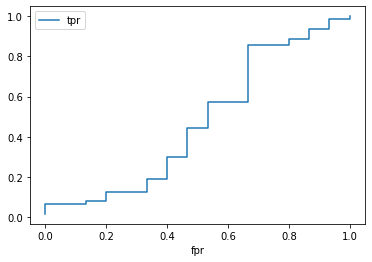

In [ ]:
# list_auc=[]

# list_vals2_temp_top = []
# list_vals2_temp_bottom = []
# list_vals2 = []

# for k,v in dict_tsn_conf.items():
#     g1,g2=k
#     if g1 not in cosmic_genes and g2 not in cosmic_genes and g1 in genes and g2 in genes: 
#         if v>=top_n:
#             list_vals2_temp_top.append([g1,g2,dict_mex[m][g1][g2],1])
#         elif v<=bottom_n:
#             list_vals2_temp_bottom.append([g1,g2,dict_mex[m][g1][g2],0])

# for i in trange(100):

    
#     list_vals2 = random.sample(list_vals2_temp_top,len(dict_tsn_conf_cosmic_nb_top))+random.sample(list_vals2_temp_bottom,len(dict_tsn_conf_cosmic_nb_bottom))

#     df_rank_nc = pd.DataFrame(list_vals2, columns=['g1', 'g2', 'mex','class'])
#     df_rank_nc.sort_values('mex', inplace=True,ascending=False)

#     '''
#     TPR = Sensitivity = sum_true/len(dict_tsn_conf_cosmic_nb_top)
#     FPR = 1-Specificity = Sum_false/len(dict_tsn_conf_cosmic_nb_bottom)
#     '''

#     list_sum_true_nc =[]
#     list_sum_false_nc = []

#     count_true_nc=0
#     count_false_nc=0
#     for idx, row in df_rank_nc.iterrows():
#         cls = row['class']
#         if cls==0:
#             count_false_nc+=1
#         elif cls == 1:
#             count_true_nc+=1
#         list_sum_true_nc.append(count_true_nc)
#         list_sum_false_nc.append(count_false_nc)

#     tpfn_nc = float(count_true_nc)
#     fptn_nc = float(count_false_nc)
#     df_rank_nc['sum_true'] = list_sum_true_nc
#     df_rank_nc['sum_false'] = list_sum_false_nc
#     df_rank_nc['tpr'] = [float(v)/tpfn_nc for v in list_sum_true_nc]
#     df_rank_nc['fpr'] = [float(v)/fptn_nc for v in list_sum_false_nc]

    
# #     df_rank_nc

#     list_auc.append(auc(df_rank_nc['fpr'],df_rank_nc['tpr']))
    
# np.median(list_auc)

In [ ]:
# df_rank_nc

g1       g2       mex  class  sum_true  sum_false       tpr  fpr
420  PLEKHA5  ARHGEF9  3.247271      1         1          0  0.001818  0.0
450    GABPA    HCFC1  2.904993      1         2          0  0.003636  0.0
156    HACE1   PLXNA2  2.860822      1         3          0  0.005455  0.0
130    RPTOR     ULK1  2.620788      1         4          0  0.007273  0.0
263     RIF1      BOC  2.619804      1         5          0  0.009091  0.0
..       ...      ...       ...    ...       ...        ...       ...  ...
271    IFT74    IFT57  0.003261      1       546        106  0.992727  1.0
539    GMCL1     TLK2  0.001641      1       547        106  0.994545  1.0
174  POLDIP3    PIBF1  0.001545      1       548        106  0.996364  1.0
101   NSFL1C    GSK3B  0.001313      1       549        106  0.998182  1.0
219   MARCH6     SQLE  0.000348      1       550        106  1.000000  1.0

[656 rows x 8 columns]

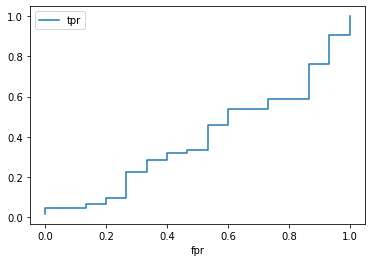

In [ ]:
# df_rank_nc.plot(x='fpr',y='tpr')

In [ ]:
auc(df_rank_nc['fpr'],df_rank_nc['tpr'])

0.4793310463121784

In [ ]:
a = [1,2,3]
b = [4,5,6]

In [ ]:
for k,v in dict_mex['wext'].items():
    if k=='MCRS1':
        print(k,len(v))

MCRS1 5745


In [ ]:
'MCRS1' in cosmic_genes

False

In [ ]:
df_rank

g1       g2       mex  class  sum_true  sum_false       tpr  fpr
86    TP53   CDKN1A  9.679443      1         1          0  0.002463  0.0
277  PTPRK    ERBB2  4.660211      1         2          0  0.004926  0.0
243    ATM    SMC1A  4.487069      1         3          0  0.007389  0.0
166  NCOR1  SMARCA4  4.455719      1         4          0  0.009852  0.0
106   CUX1      RB1  4.377888      1         5          0  0.012315  0.0
..     ...      ...       ...    ...       ...        ...       ...  ...
107   BRAF   MAP3K1  0.006881      1       402         62  0.990148  1.0
215   VAV1    ERBB2  0.005829      1       403         62  0.992611  1.0
234   JAK2     EGFR  0.005381      1       404         62  0.995074  1.0
55   H3F3B     DAXX  0.003539      1       405         62  0.997537  1.0
307   SPEN   PIK3R1  0.001433      1       406         62  1.000000  1.0

[468 rows x 8 columns]

In [ ]:
'CHEK2' in cosmic_genes 

True

In [ ]:
round(0.2545687555,2)

0.25

In [ ]:
{0.125454888:12}

{0.125454888: 12}